# Compression
References:
- https://pdfs.semanticscholar.org/f1b2/0a5681e6ef7080e5b5fbce81911c6873543c.pdf

What We plan to do is this:

![logDomainComp](img/logDomainComp.png)


In [98]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Gain Computer
![gainComputer](img/gainCompute.png)

For simplicity, we will build one without a knee:


$    y_G = \left\{\begin{array}{lr}
        X_G,  & x_G \leq T \\
        T+(x_G-T)/R, & x_G > T
        \end{array}\right\}$


In [99]:
def gainCompute(xg, threshold, ratio):
    yg = np.zeros_like(xg)
    under = xg<=threshold
    over = xg>threshold
    yg[under] = xg[under]
    yg[over] = threshold + (xg[over]-threshold)/ratio
    return yg
    

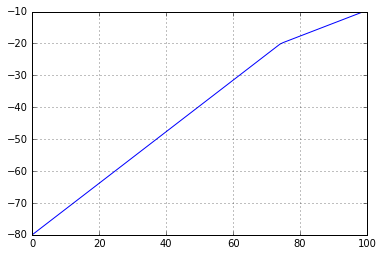

In [100]:
x = np.linspace(-80, 0, 100)
y = gainCompute(x,-20, 2)
plt.grid()
plt.plot(y)
plt.show()

### Faust implementation:
```
gainComputer(x,T,R) = ba.if((x<=T),x,comp) with {
  comp = T+(x-T)/R;
};
```

# Peak detector
("Branching Smooth Peak Detector")

$    y_L(n) = \left\{\begin{array}{lr}
        \alpha_A y_L(n-1)+(1-\alpha_A)x_L(n),  & \text{for } x_L(n)\gt y_L(n-1)\\
        \alpha_R y_L(n-1)+(1-\alpha_R)x_L(n),  & \text{for } x_L(n)\leq y_L(n-1)
        \end{array}\right\}$

To calculate the $\alpha$ pars (which are coefficients between 0 and 1) from actual time constants in seconds we can use:

$\alpha=e^{-1/(\tau f_s)}$
where $\tau$ is time in seconds, and $f_s$ is the sample rate.


In [36]:
def peakDetector(x,tA,tR,sr):
    
    aA = np.exp(-1/(tA*sr))
    aR = np.exp(-1/(tR*sr))
    
    N = len(x)
    y1 = 0
    Y = np.zeros_like(x)
    
    for n in range(N):
        if x[n]>y1:
            y1 = aA*y1+(1-aA)*x[n]
            Y[n] = y1
        else:
            y1 = aR*y1+(1-aR)*x[n]
            Y[n] = y1
    return Y            

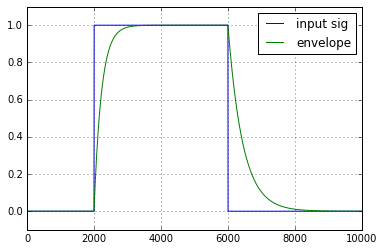

In [37]:
x = np.zeros(10000)
x[2000:6000]=1
env = peakDetector(np.abs(x), 0.005, 0.01,44100)
plt.plot(x, label='input sig')
plt.plot(env, label='envelope')
plt.grid()
plt.ylim([-0.1, 1.1])
plt.legend()
plt.show()

### Faust implementation(more or less):
```
peakDetector(x,att,rel) = lag_ud(att,rel,x);
```




## Combining both to get a compressor
We now just need to define lin ton dB and back funcktions and plug it all together
![logDomainComp](img/logDomainComp.png)


In [38]:
def dBToA(X):
    """Given a np.array calculates linear from dB values"""
    P1 = 10.**(X/20.)
    return P1
def aToDb(linArray, accuracy = 10):
    # A = 20*log10(V2/V1)\n    
    dbArray = 20.*np.log10(np.clip(linArray,10**-accuracy,10**accuracy))
    return dbArray


In [39]:
def compressor(x, thresh, ratio, makeup, attack, release, sr):
    dbVals = aToDb(np.abs(x))
    gainOut = gainCompute(dbVals,thresh,ratio)
    toPeakDetect = dbVals-gainOut
    toLin = makeup-peakDetector(toPeakDetect,attack,release,sr)
    sideChainOut = dBToA(toLin)
    y = x*sideChainOut
    return y,sideChainOut

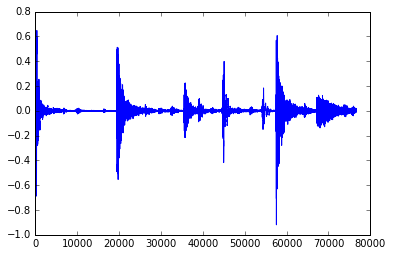

In [40]:
x,sr = librosa.load('drumLoop.wav')
plt.plot(x)
plt.show()

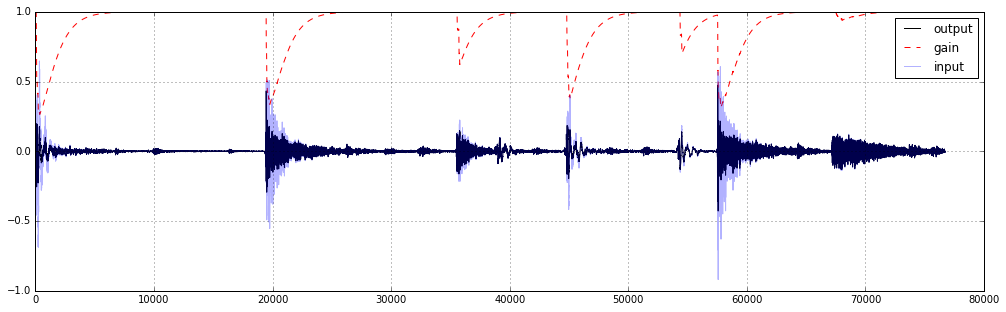

In [41]:
thresh = -20
ratio = 5
attack = 0.001
release = 0.05
makeup = 0
y,gainLin = compressor(x, thresh, ratio, makeup, attack, release, sr)

plt.figure(figsize=[17,5])
plt.plot(y,'k', label='output',)
plt.plot(gainLin,'r--', label='gain' )
plt.plot(x,'b', label='input', alpha=0.3)
plt.grid()
plt.legend(loc='best')
plt.show()

### Complete Compressor Faust Implementation
```
import("stdfaust.lib");

threshold = hslider("threshold",0,-30,0,0.1);
ratio = hslider("ratio",4,1,10,0.1);
attack = hslider("attack",2,0.1,30,0.1);
release = hslider("release",30,0.1,300,0.1);
makeup = hslider("makeup", 0,-20,20,0.1);

gainComputer(T,R,x) = ba.if((x<=T),x,comp) with {
  comp = T+(x-T)/R;
};

peakDetector(att,rel,x) = x:an.amp_follower_ar(att,rel);

sidechain(threshold,ratio,attack,release,makeup,x) = x:abs:ba.linear2db<:(_,gainComputer(threshold,ratio)*-1):+:peakDetector(attack,release):_*-1:_+makeup:ba.db2linear;


compressor(threshold,ratio,attack,release,makeup,x) = x<:(_,sidechain(threshold,ratio,attack,release,makeup)):*:_;
compressorDebug(threshold,ratio,attack,release,makeup,x) = x<:(_,sidechain(threshold,ratio,attack,release,makeup)):_,(_<:(_,_)):_*_,_; //debug outpts sidechain to 2nd channel.

// process= _:compressor(threshold,ratio,attack,release,makeup):_; //real compressor
process= _:compressorDebug(threshold,ratio,attack,release,makeup); //debugger (outputs gain also)



```

In [5]:
!cat compressor.dsp

import("stdfaust.lib");

threshold = hslider("threshold",0,-30,0,0.1);
ratio = hslider("ratio",4,1,10,0.1);
attack = hslider("attack",2,0.1,30,0.1);
release = hslider("release",30,0.1,300,0.1);
makeup = hslider("makeup", 0,-20,20,0.1);

gainComputer(T,R,x) = ba.if((x<=T),x,comp) with {
  comp = T+(x-T)/R;
};

peakDetector(att,rel,x) = x:an.amp_follower_ar(att,rel);

sidechain(threshold,ratio,attack,release,makeup,x) = x:abs:ba.linear2db<:(_,gainComputer(threshold,ratio)*-1):+:peakDetector(attack,release):_*-1:_+makeup:ba.db2linear;


compressor(threshold,ratio,attack,release,makeup,x) = x<:(_,sidechain(threshold,ratio,attack,release,makeup)):*:_;
compressorDebug(threshold,ratio,attack,release,makeup,x) = x<:(_,sidechain(threshold,ratio,attack,release,makeup)):_,(_<:(_,_)):_*_,_; //debug outpts sidechain to 2nd channel.

// process= _:compressor(threshold,ratio,attack,release,makeup):_; //real compressor
process= _:compressorDebug(threshold,ratio,attack,release,makeup); //debugger (outp

### Compile to cmd line program
(Check your platform and all the requirements. You will need a compatible compiler etc.)
- first to C++ 
- then to binary

There are a lot of arguments it the following commands. Most of them are only to get a very efficient program.
You could also compile from foust to C++ with just 

`faust compressor.dsp -a /opt/faust/architecture/sndfile.cpp -o BUILDS/compressor1.cpp`

And from c++ to binary with just:

`g++ -lsndfile BUILDS/compressor1.cpp -o BUILDS/compressor1`


In [23]:
!faust compressor.dsp -a /opt/faust/architecture/sndfile.cpp -lv 0 -vs 512 -g -omp -o BUILDS/compressor1.cpp

In [24]:
!g++ -O3 -ffast-math -ftree-vectorize -mfpmath=sse -msse -msse2 -msse3 -fopenmp -lsndfile BUILDS/compressor1.cpp -o BUILDS/compressor1

In [25]:
!ls BUILDS/

compressor1  compressor1.cpp


In [93]:
!BUILDS/compressor1 drumLoop.wav compOut.wav -attack 0.001 -release 0.2 -ratio 10 -threshold -25 -makeup 10

input file drumLoop.wav
output file compOut.wav


In [94]:
y,sr = librosa.load('compOut.wav',sr=None,mono=False)

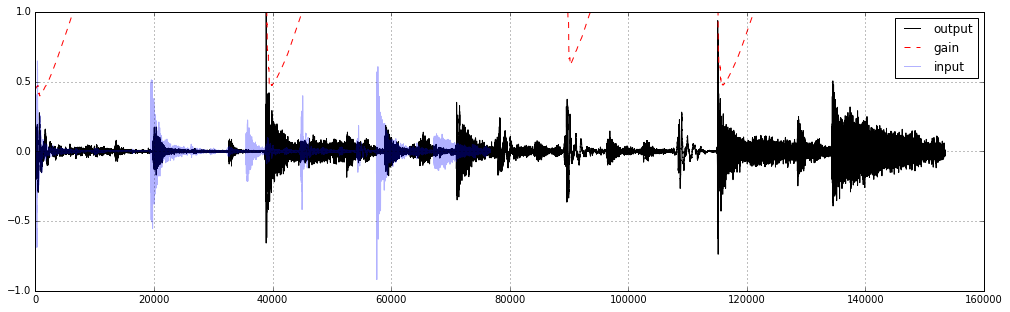

In [95]:
plt.figure(figsize=[17,5])
plt.plot(y[0,:],'k', label='output',)
plt.plot(y[1,:],'r--', label='gain' )
plt.plot(x,'b', label='input', alpha=0.3)
plt.grid()
plt.legend(loc='best')
plt.show()


In [96]:
from IPython.display import Audio

In [97]:
Audio(data=y[0,:], rate=44100)